хочу срезать края по 5% программно, на основе этого сформировать программу 

ось X в tables - это ось y в привычных графиках. И соответственно наоборот.

In [1]:
%reload_ext autoreload
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
from final_make_samples_and_patients_data import data_heal, data_sick, data_very_sick, \
                                    patients_mean_heal, patients_mean_sick, patients_mean_very_sick 
from make_ready_data.create_features_indeces import get_labels_and_features_indeces

plot_labels, _ = get_labels_and_features_indeces()
print(plot_labels)

TQ_manualis dropped
['QTc', 'JTc', 'TpeakTend', 'TQ', 'RR']


In [2]:
def create_or_clean_dir(new_dir_name, dir_name='.'):
    plots_dir = dir_name + '\\' + new_dir_name
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    else:
        for the_file in os.listdir(plots_dir):
            file_path = os.path.join(plots_dir, the_file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path) # unlink (delete) the file
            except Exception:
                print("Except catched")


In [79]:
def form_thresh(vec1, vec2, vec3, STEP=0.005, n=2, p=0.005):
    vec = np.concatenate((vec1, vec2, vec3))
    n_cut = np.round(p*vec.size)
    start = np.round(vec.min(), n)
    stop = np.round(vec.max(), n)
    thr = np.arange(start, stop+STEP, STEP)
    e1=0; e2=0;
    for i in range(thr.size):
        if (vec<thr[i]).sum() >= n_cut:
            e1 = i
            break
            
    for i in range(thr.size-1, 0, -1):
        if (vec>thr[i]).sum() >= n_cut:
            e2 = i
            break

    return thr[e1:e2]


def get_vec_by_feat(data_heal, data_sick, data_very_sick, feat):
    vec_heal = data_heal[:, feat] 
    vec_sick = data_sick[:, feat] 
    vec_very_sick = data_very_sick[:, feat]     
    return vec_heal, vec_sick, vec_very_sick

def form_lists_for_plots(vec, thresholds_space, WIN_SIZE=92):
# -------------------???????-------------------
#     n_slices = vec.size // WIN_SIZE # колво окон
#     v = vec[:n_slices*WIN_SIZE]
    v = vec
    bins_size = thresholds_space.size - 1 
    bins = np.zeros(bins_size)
    list_bins = [None] * bins_size
    for i in range(bins_size):
        e1 = thresholds_space[i]
        e2 = thresholds_space[i+1]
        bins[i] += ((v>e1) * (v<e2)).sum()
        list_bins[i] = np.arange(v.size)[((v>e1) * (v<e2))].tolist()
    return list_bins

def get_mask(data, e1, e2):
    return (e2>data)*(data>e1)
def get_indx(data, e1, e2):
    return np.arange(data.shape[0])[(e2>data)*(data>e1)]


def form_table_for_plot(data, list_bin, threshX, threshY, feat_X, feat_Y, WIN_SIZE=92):
    sX=threshX.size-1; sY=threshY.size-1
    dataX = data[list_bin, feat_X] # data of one plot
    dataY = data[list_bin, feat_Y]
    table = np.zeros((sX, sY))
    for i in range(sX):
        for j in range(sY):
            m1 = get_mask(dataX, threshX[i], threshX[i+1])
            m2 = get_mask(dataY, threshY[j], threshY[j+1])
            table[i, j] = (m1*m2).sum()
    return table

In [93]:
plots_dir = 'plots_with_3_features'
create_or_clean_dir(plots_dir)    
feat_base = 1
featX = 0
featY = 4
def create_plots_for_three_feat(data_heal, data_sick, data_very_sick, feat_base=0, feat_X=1, feat_Y=2, STEP=0.05, WIN_SIZE=92):
    vec_heal, vec_sick, vec_very_sick = get_vec_by_feat(data_heal, data_sick, data_very_sick, feat_base)
    vec_heal_X, vec_sick_X, vec_very_sick_X = get_vec_by_feat(data_heal, data_sick, data_very_sick, feat_X)
    vec_heal_Y, vec_sick_Y, vec_very_sick_Y = get_vec_by_feat(data_heal, data_sick, data_very_sick, feat_Y)

    plots_thresh_space = form_thresh(vec_heal, vec_sick, vec_very_sick, STEP=0.01, p=0.005)
    thresh_X = form_thresh(vec_heal_X, vec_sick_X, vec_very_sick_X, STEP=0.01, p=0.005)
    thresh_Y = form_thresh(vec_heal_Y, vec_sick_Y, vec_very_sick_Y, STEP=0.05, p=0.005)
#     plots_thresh_space = np.arange(0.32, 0.42, 0.01)
#     thresh_Y = np.arange(0.02, 0.15, 0.01)
#     thresh_X = np.arange(0.25, 0.32, 0.01)

    
    list_bin_heal = form_lists_for_plots(vec_heal, plots_thresh_space, WIN_SIZE=WIN_SIZE)
    list_bin_sick = form_lists_for_plots(vec_sick, plots_thresh_space, WIN_SIZE=WIN_SIZE)
    list_bin_very_sick = form_lists_for_plots(vec_very_sick, plots_thresh_space, WIN_SIZE=WIN_SIZE)
    
    tables_heal = np.empty((plots_thresh_space.size-1, thresh_X.size-1, thresh_Y.size-1))
    tables_sick = np.empty((plots_thresh_space.size-1, thresh_X.size-1, thresh_Y.size-1))
    tables_very_heal = np.empty((plots_thresh_space.size-1, thresh_X.size-1, thresh_Y.size-1))
    for i in range(plots_thresh_space.size-1):
        tables_heal[i] = form_table_for_plot(data_heal, list_bin_heal[i], thresh_X, thresh_Y, feat_X, feat_Y, WIN_SIZE)
        tables_sick[i] = form_table_for_plot(data_sick, list_bin_sick[i], thresh_X, thresh_Y, feat_X, feat_Y, WIN_SIZE)
        tables_very_heal[i] = form_table_for_plot(data_very_sick, list_bin_very_sick[i], 
                                                      thresh_X, thresh_Y, feat_X, feat_Y, WIN_SIZE)
    return tables_heal, tables_sick, tables_very_heal, plots_thresh_space, thresh_X, thresh_Y
    

tables_heal, tables_sick, tables_very_heal, plots_thresh_space, threshX, threshY = create_plots_for_three_feat(
                        data_heal, data_sick, data_very_sick, feat_base=feat_base, feat_X=featX, feat_Y=featY, 
                                    STEP=0.01, WIN_SIZE=92)

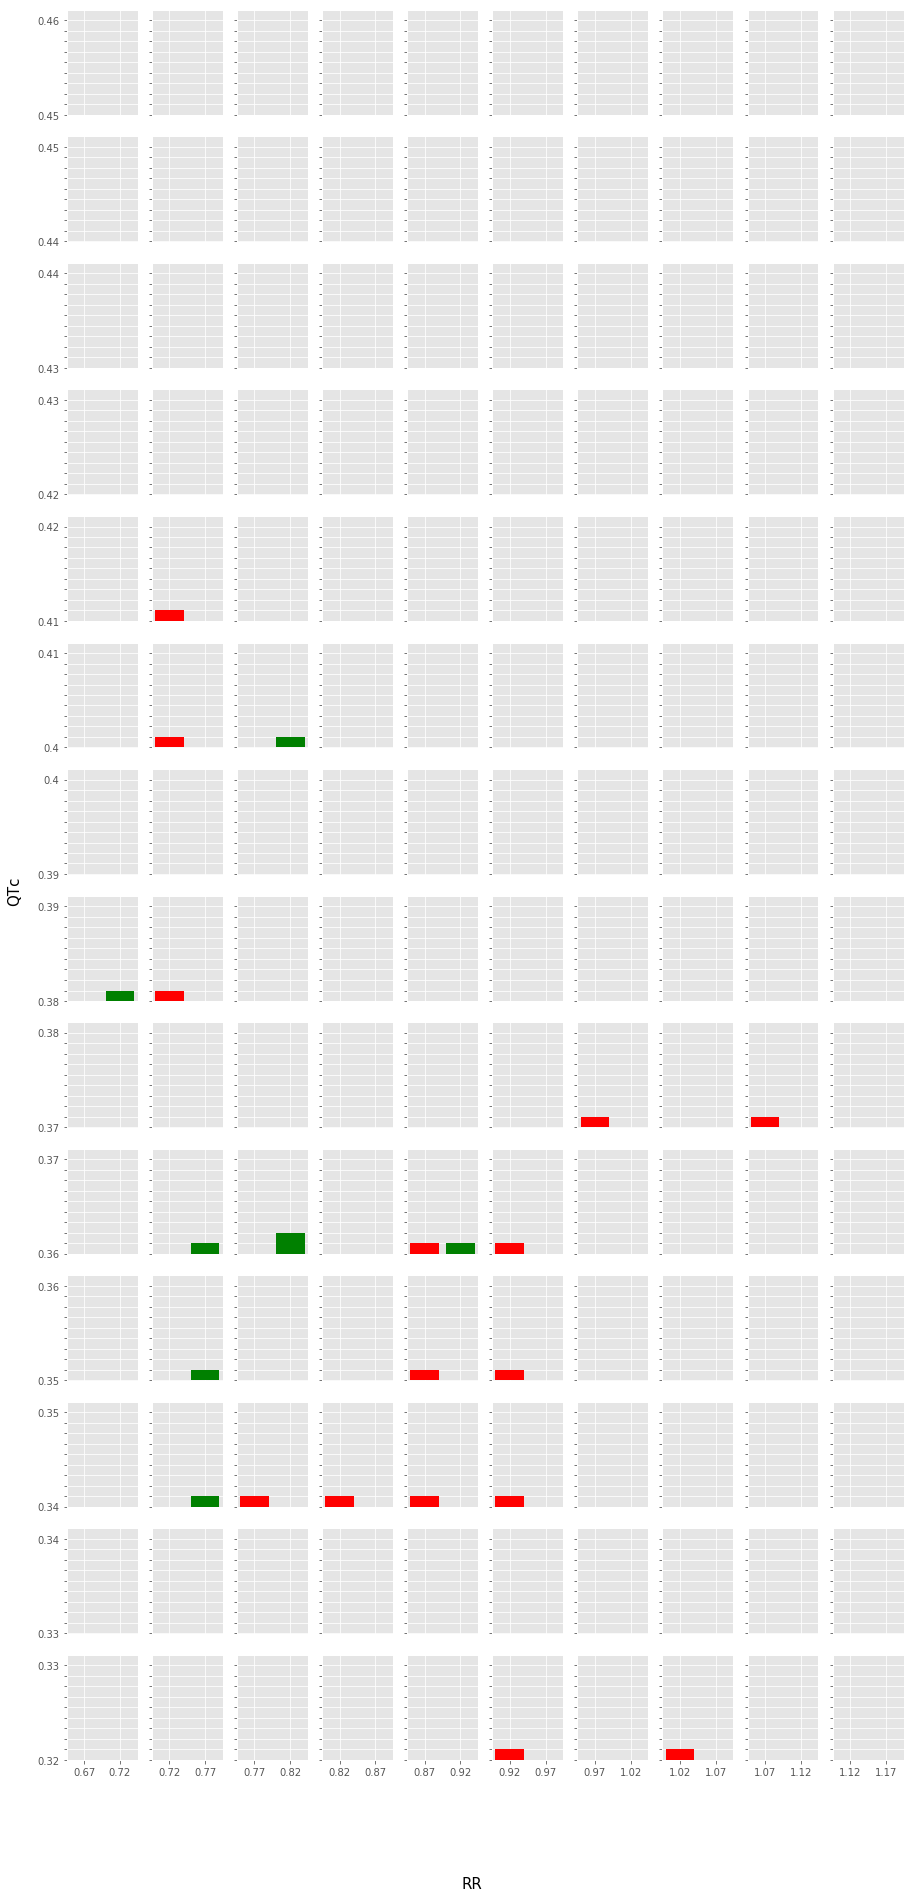

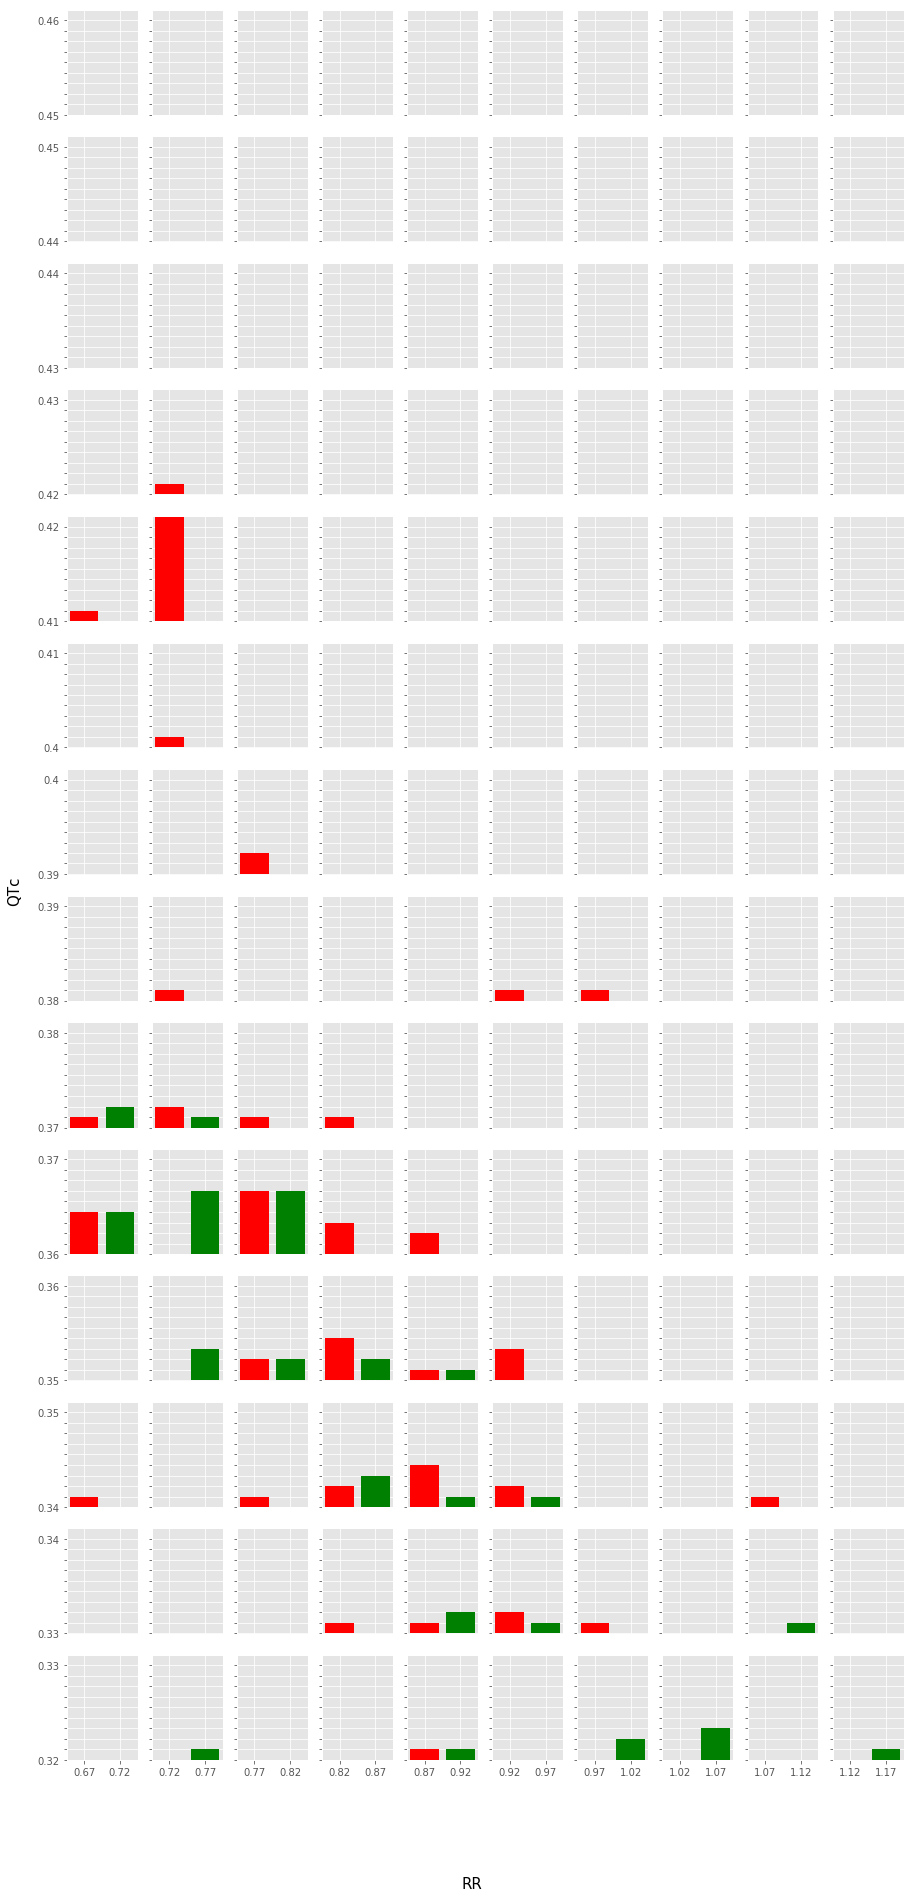

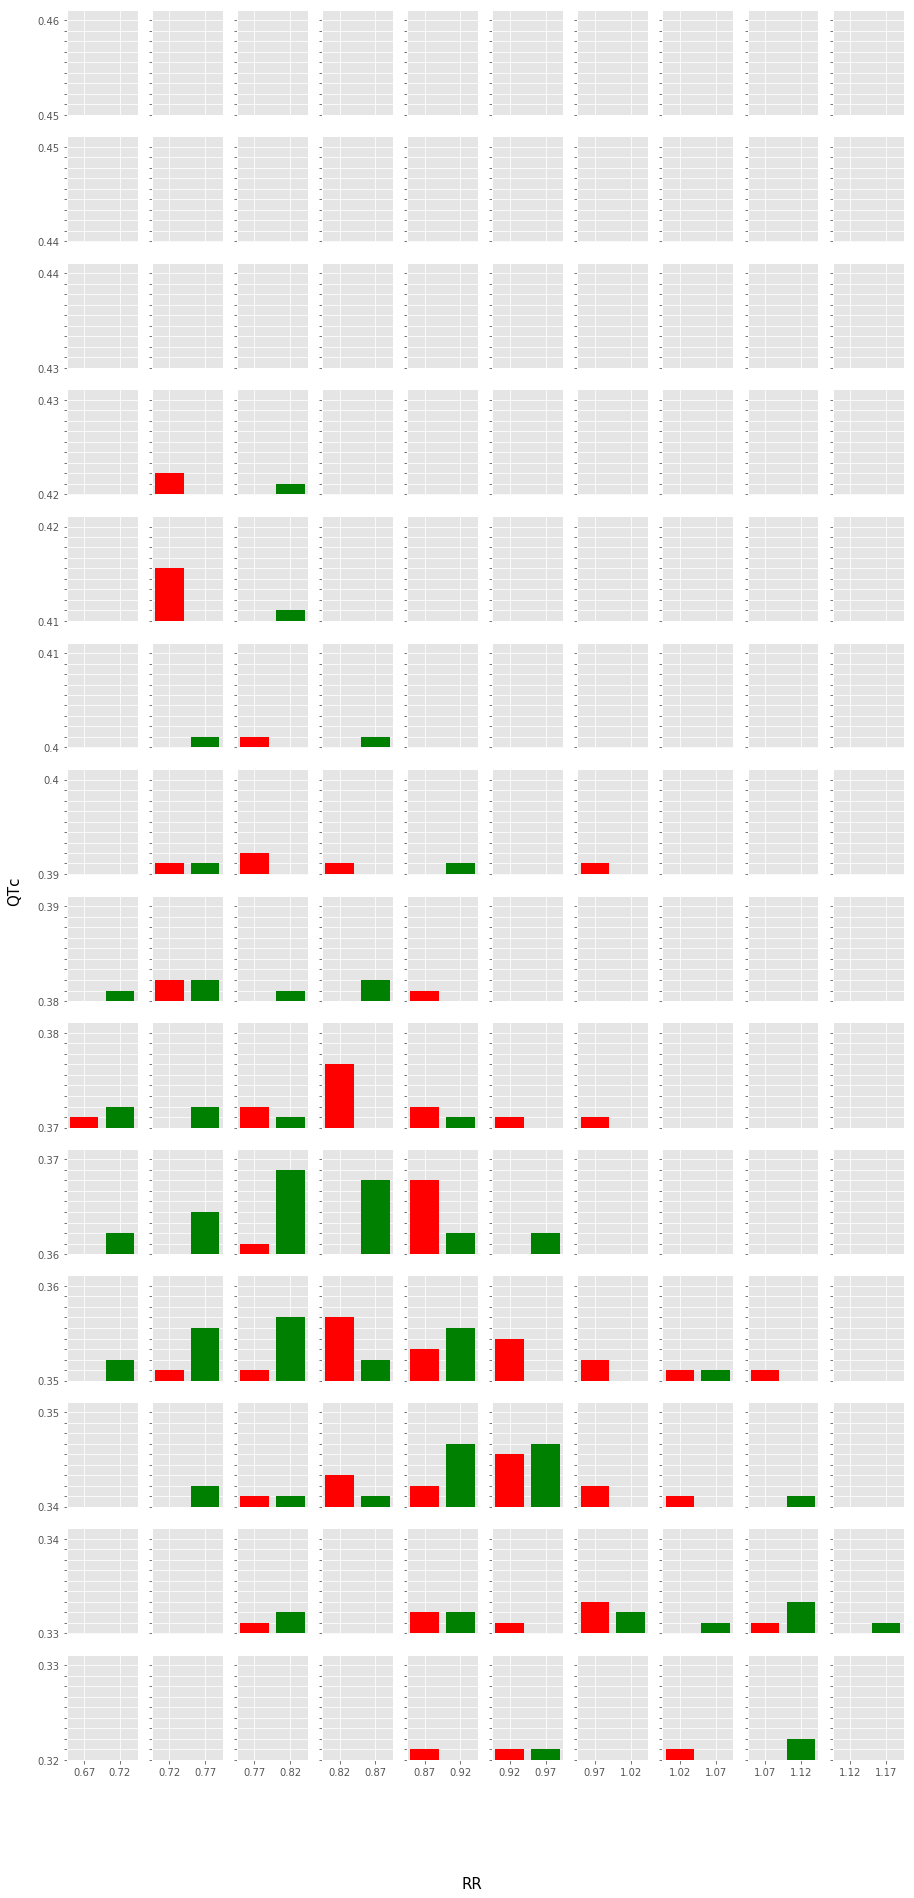

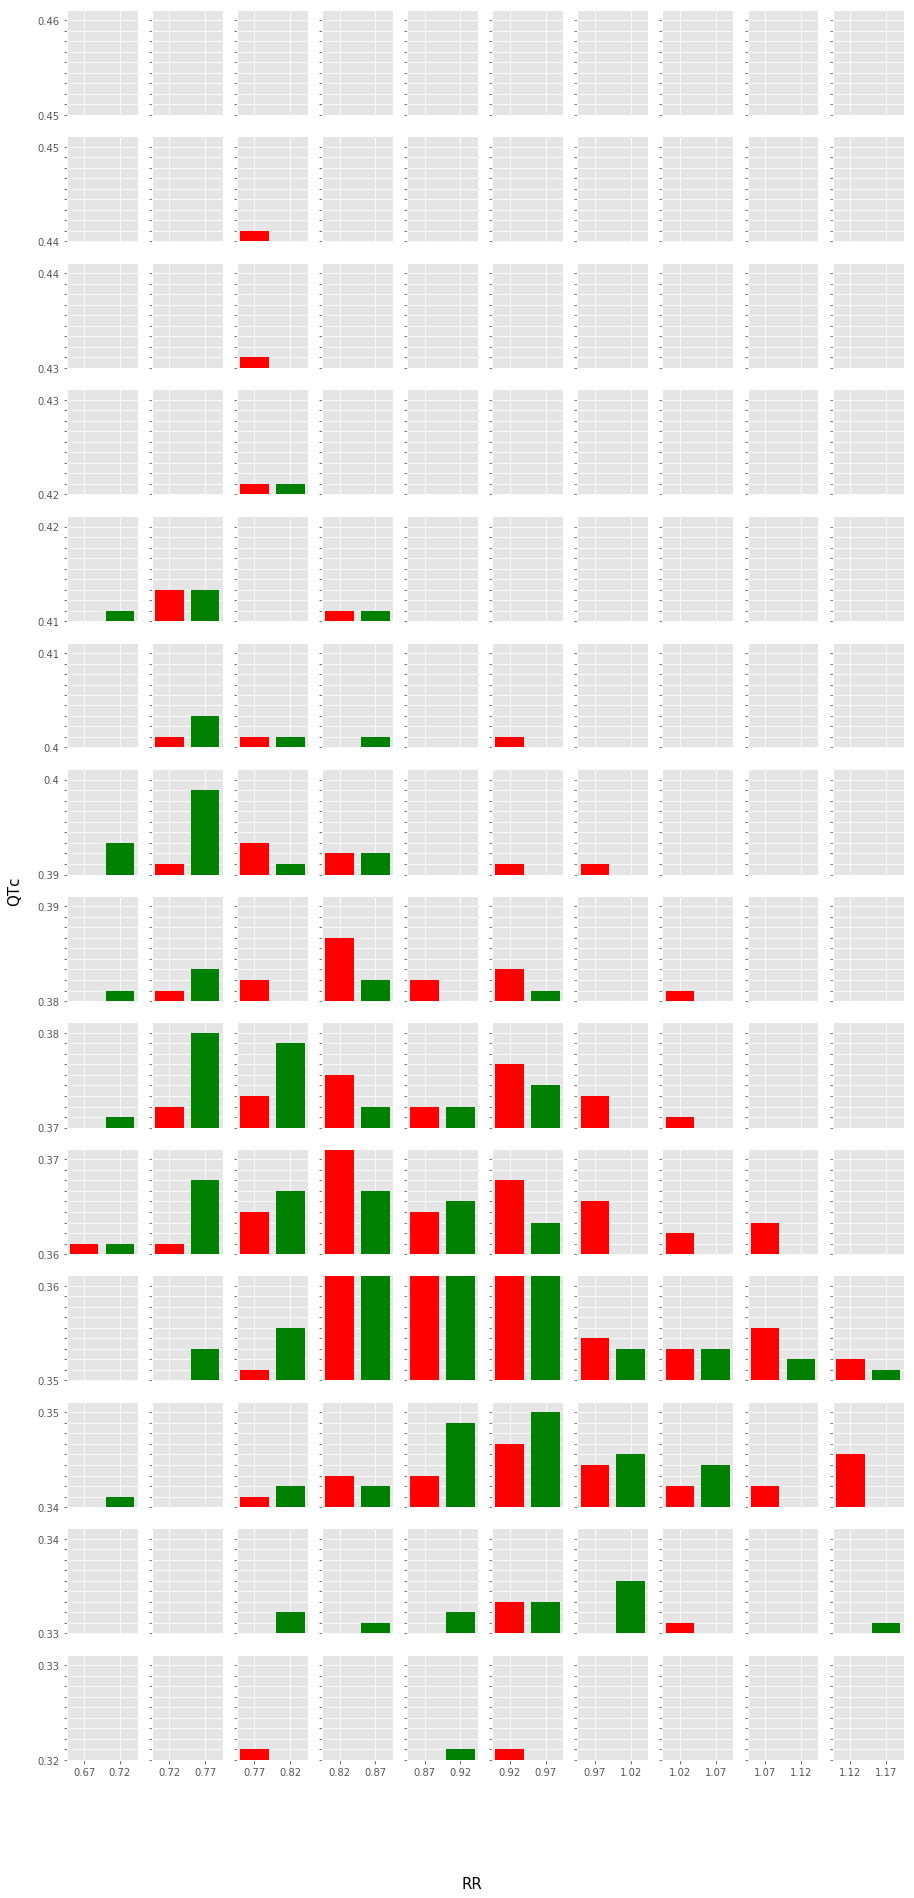

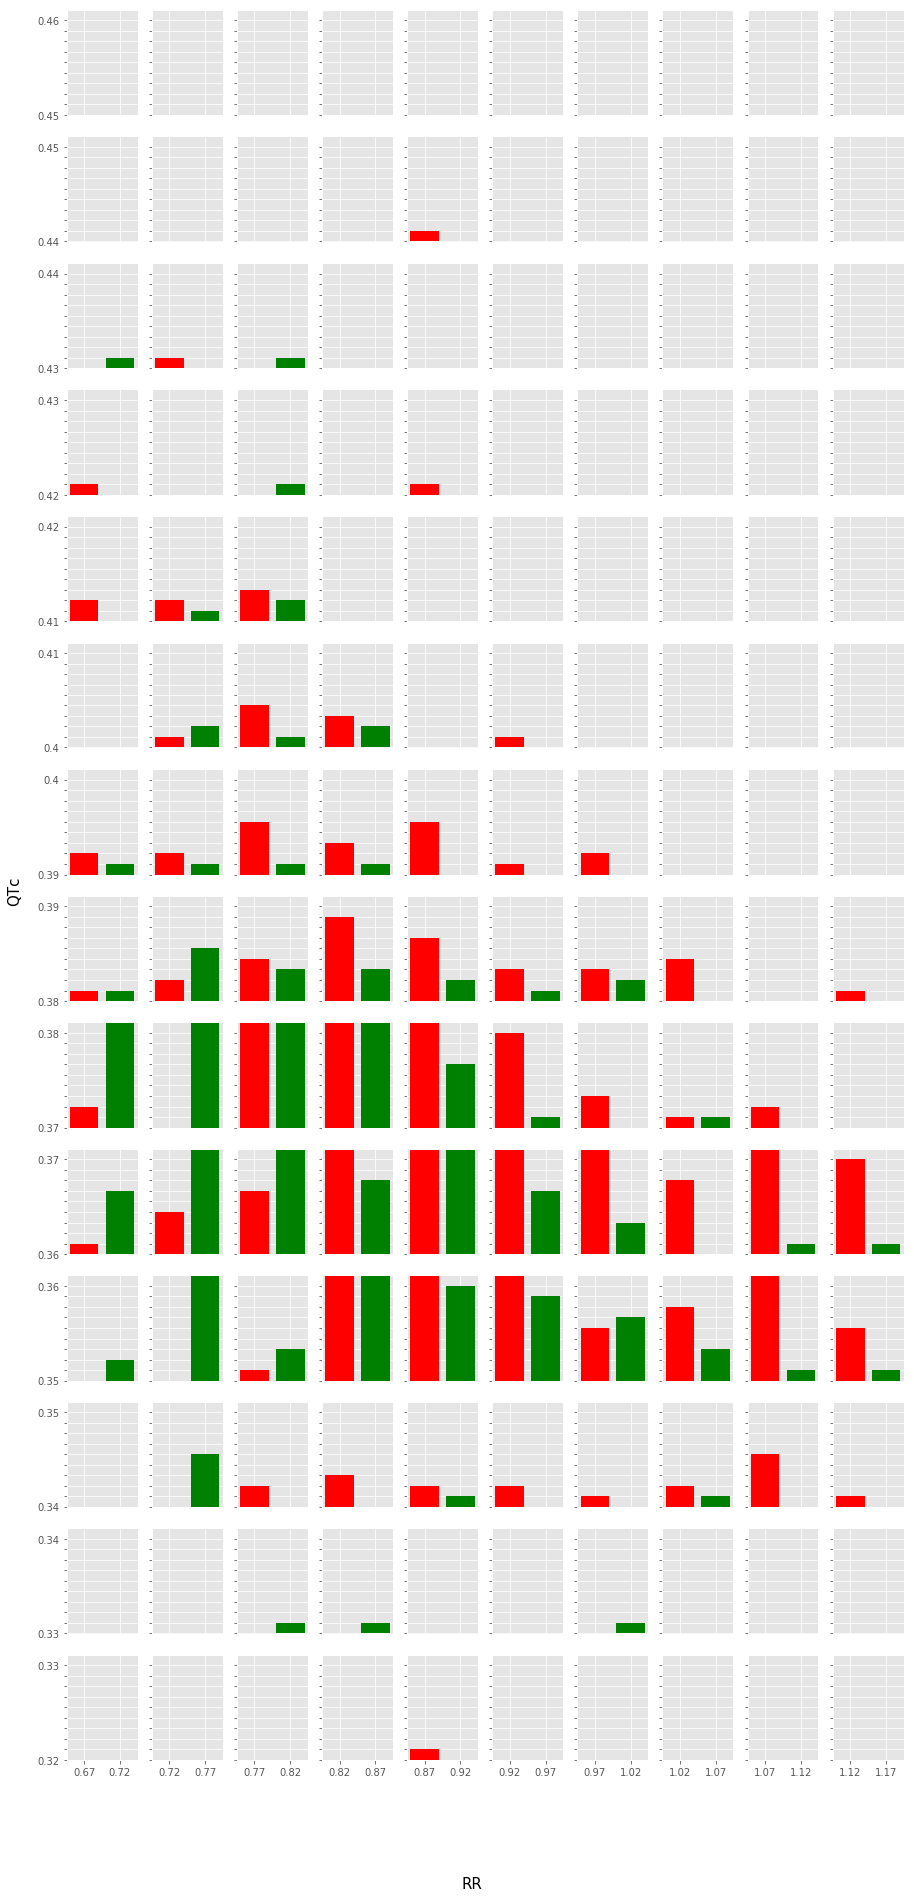

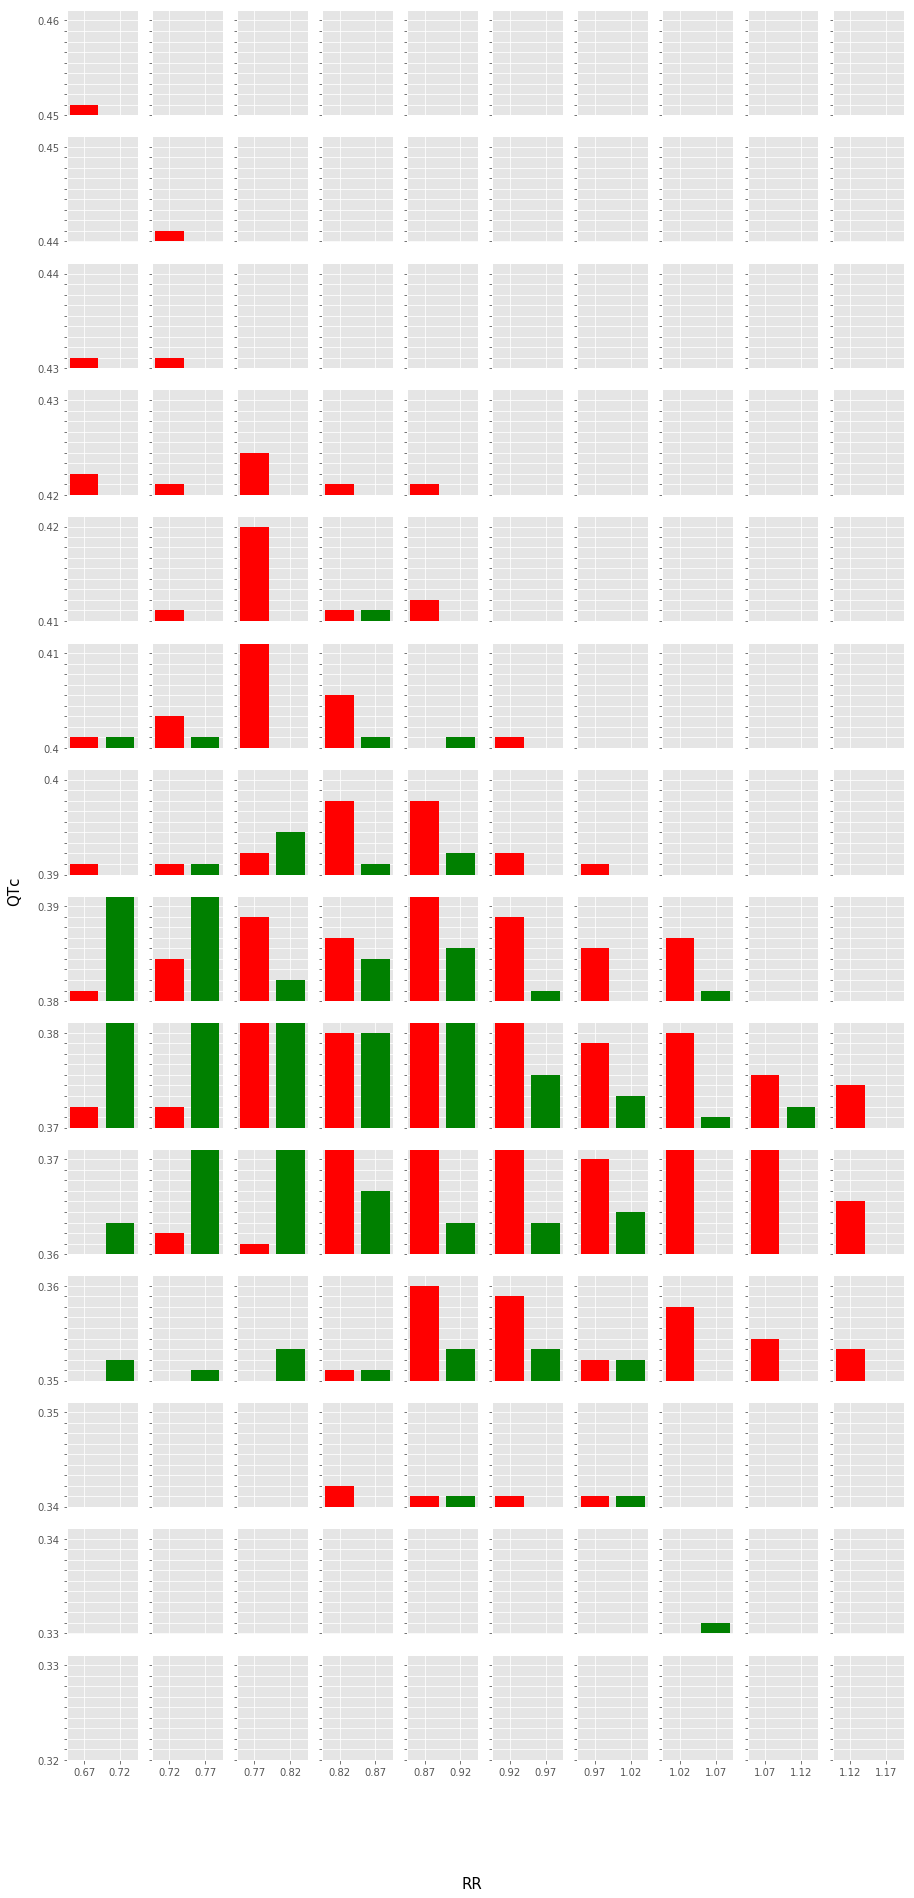

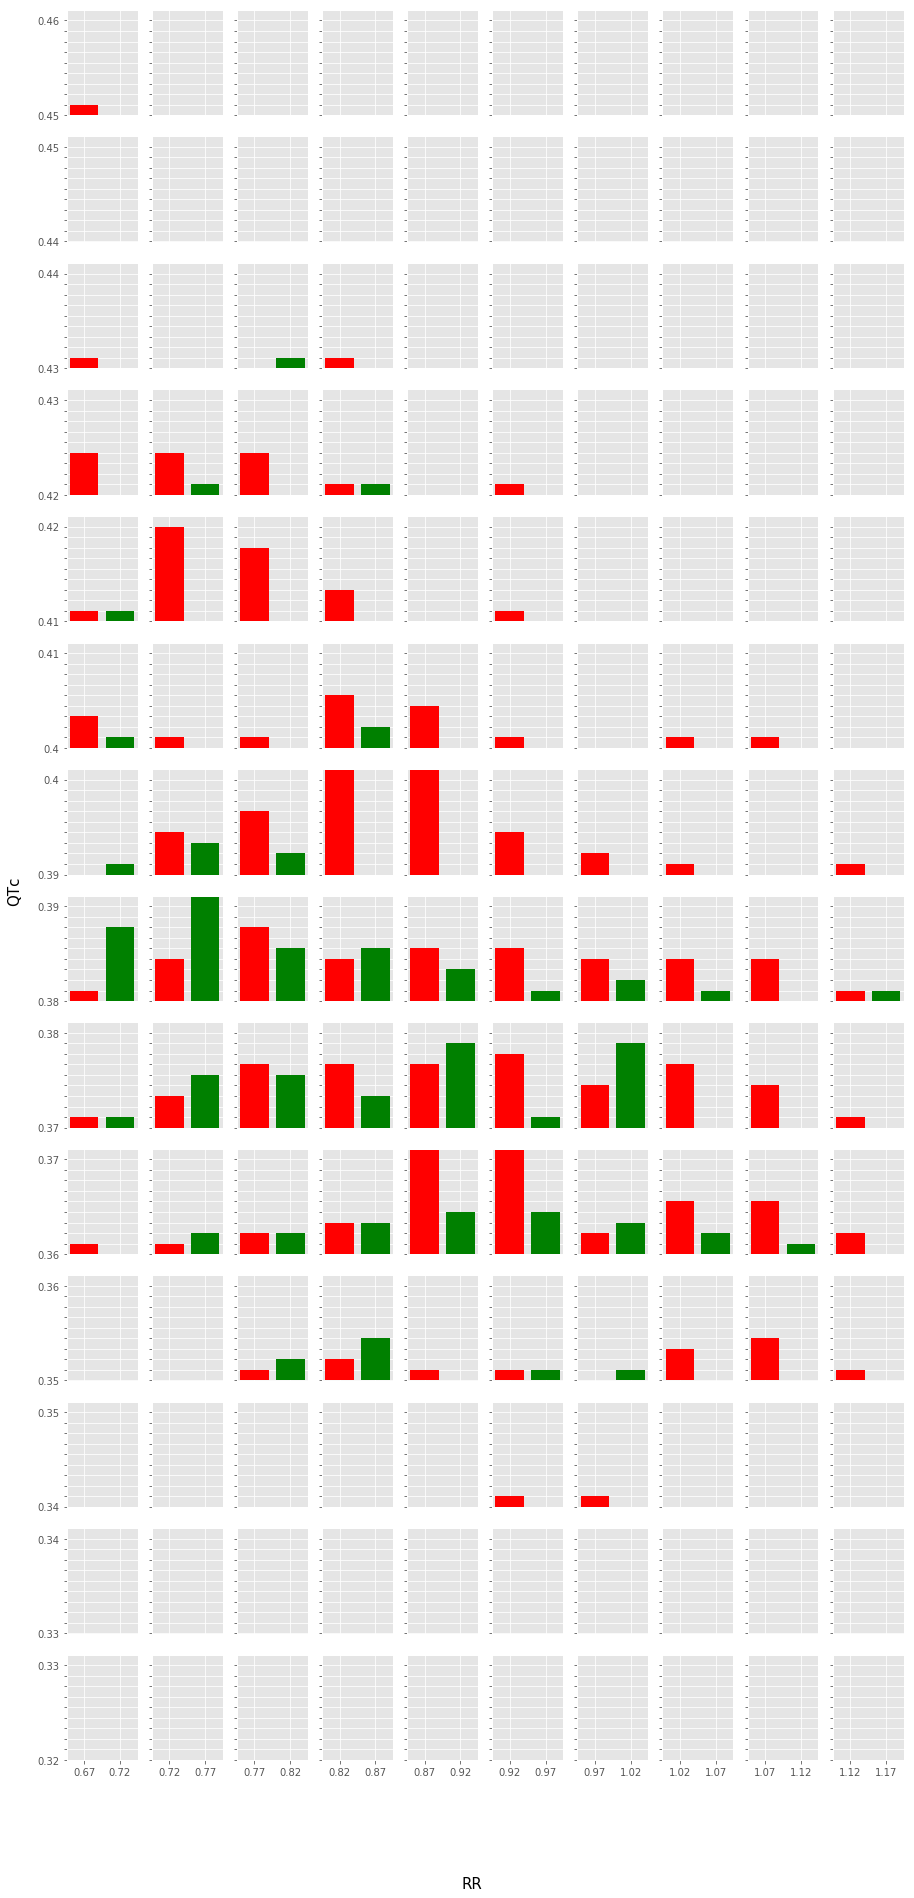

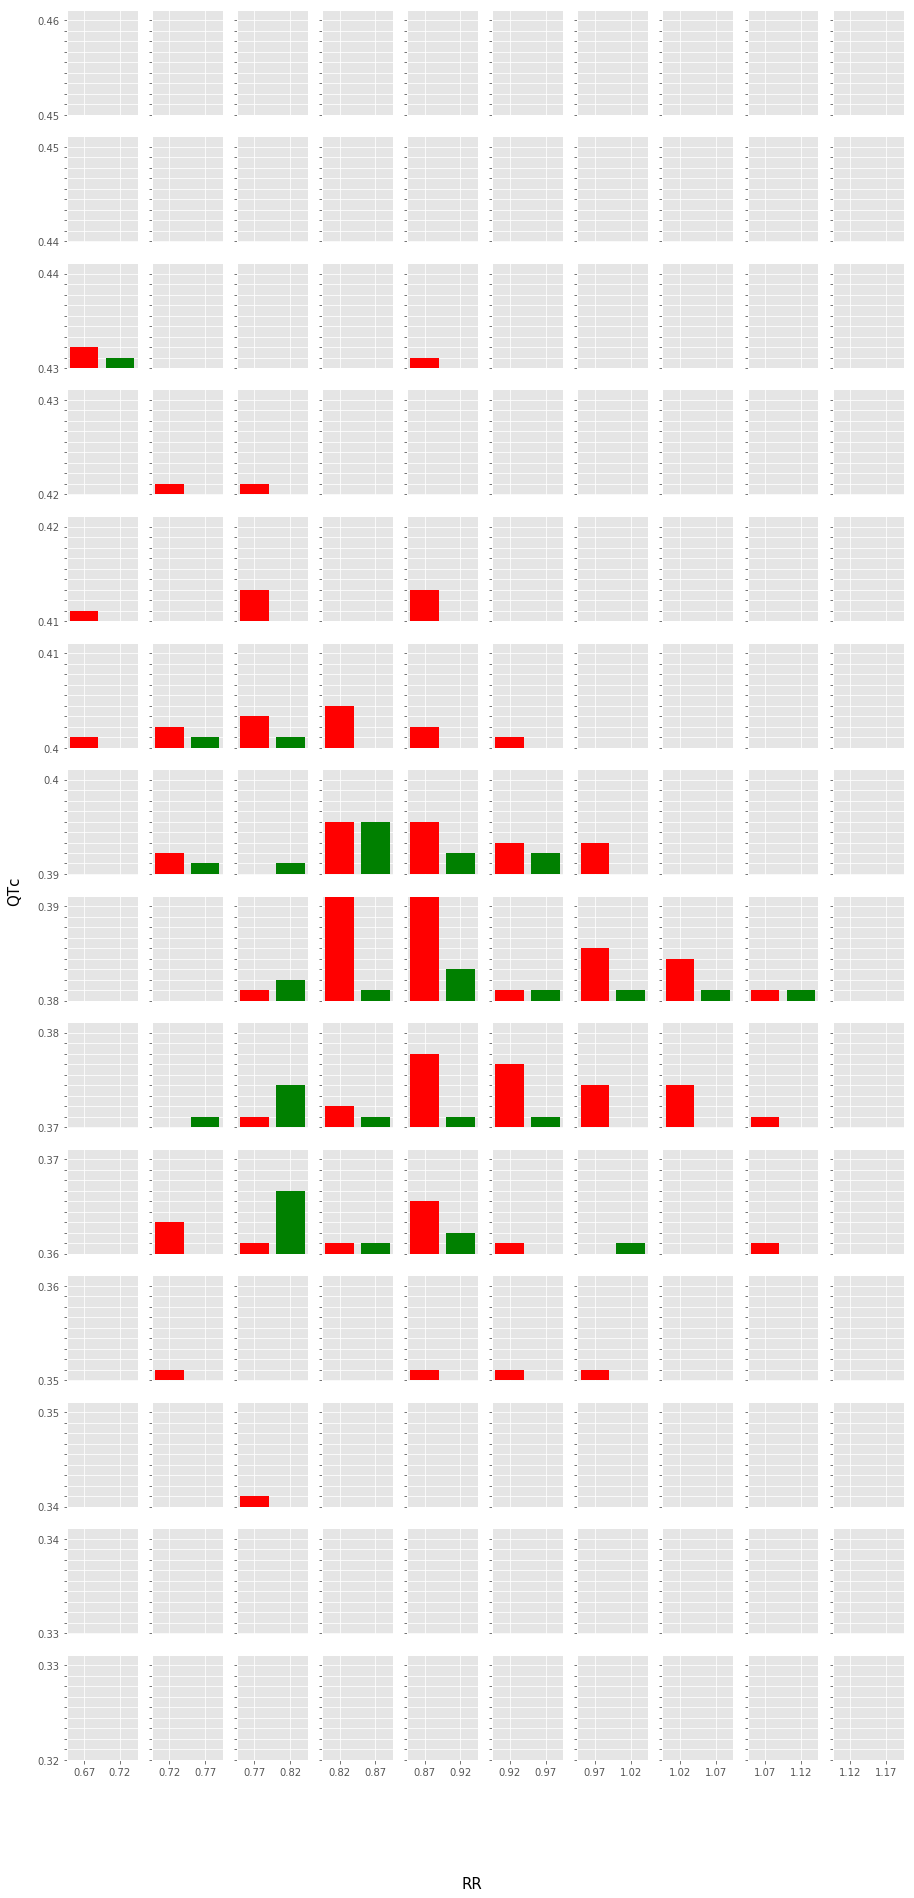

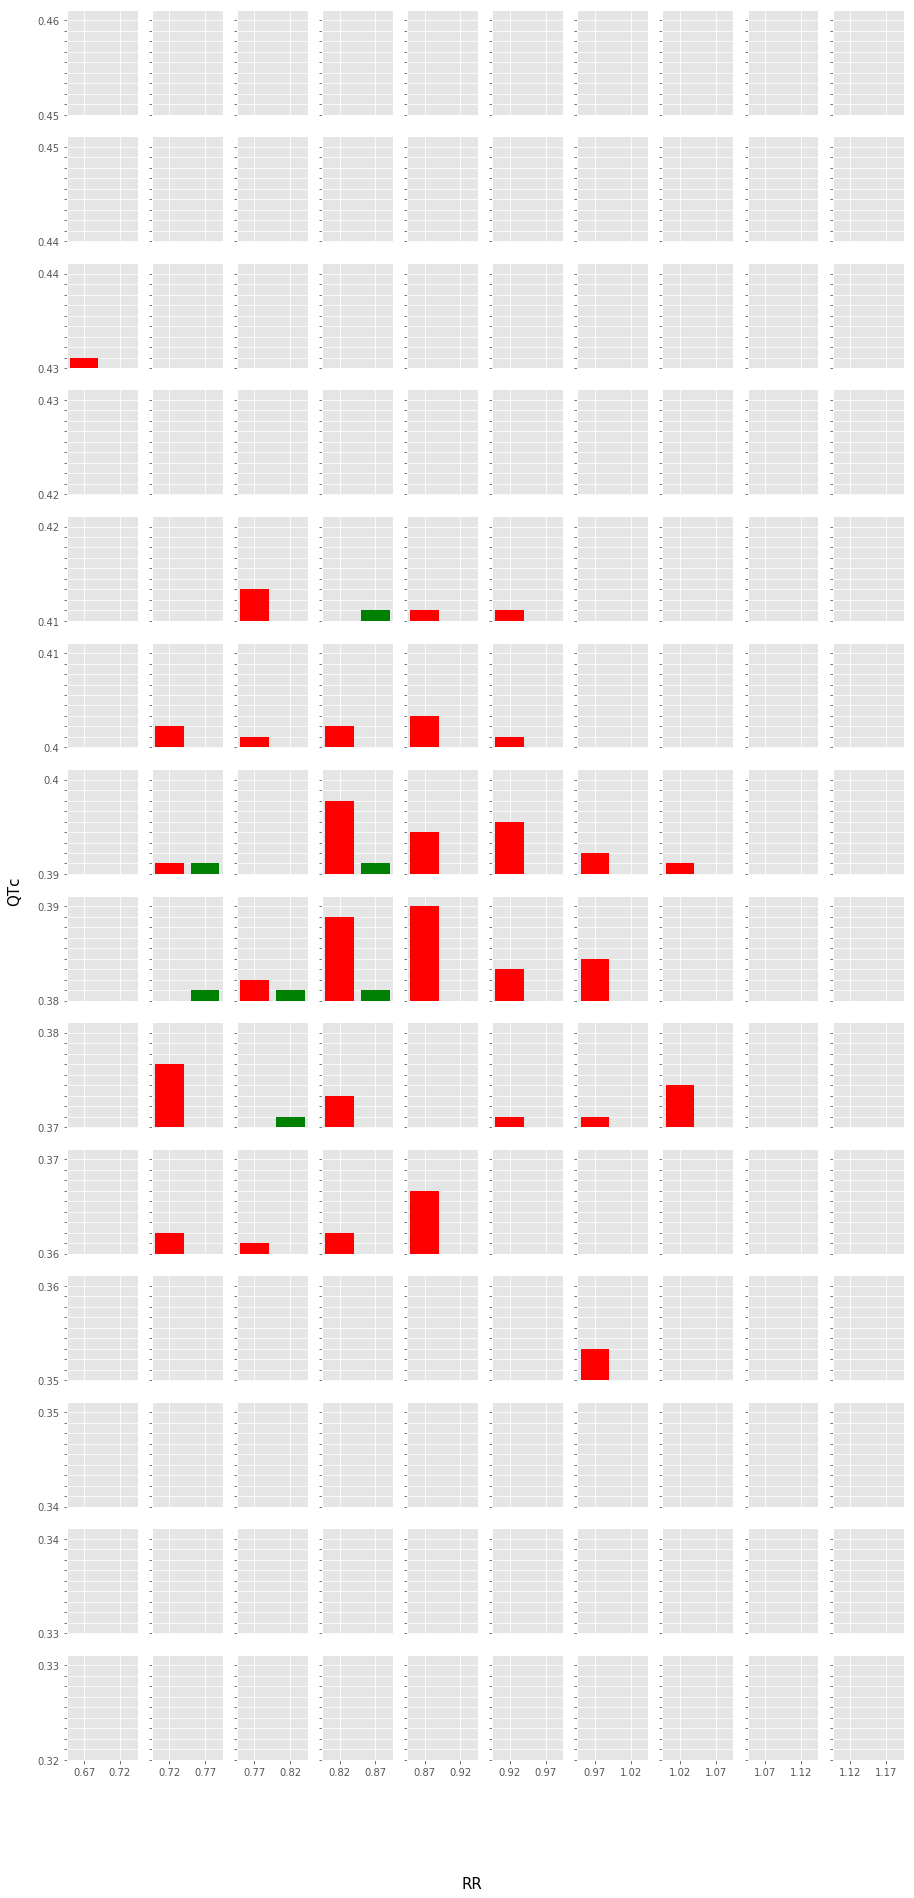

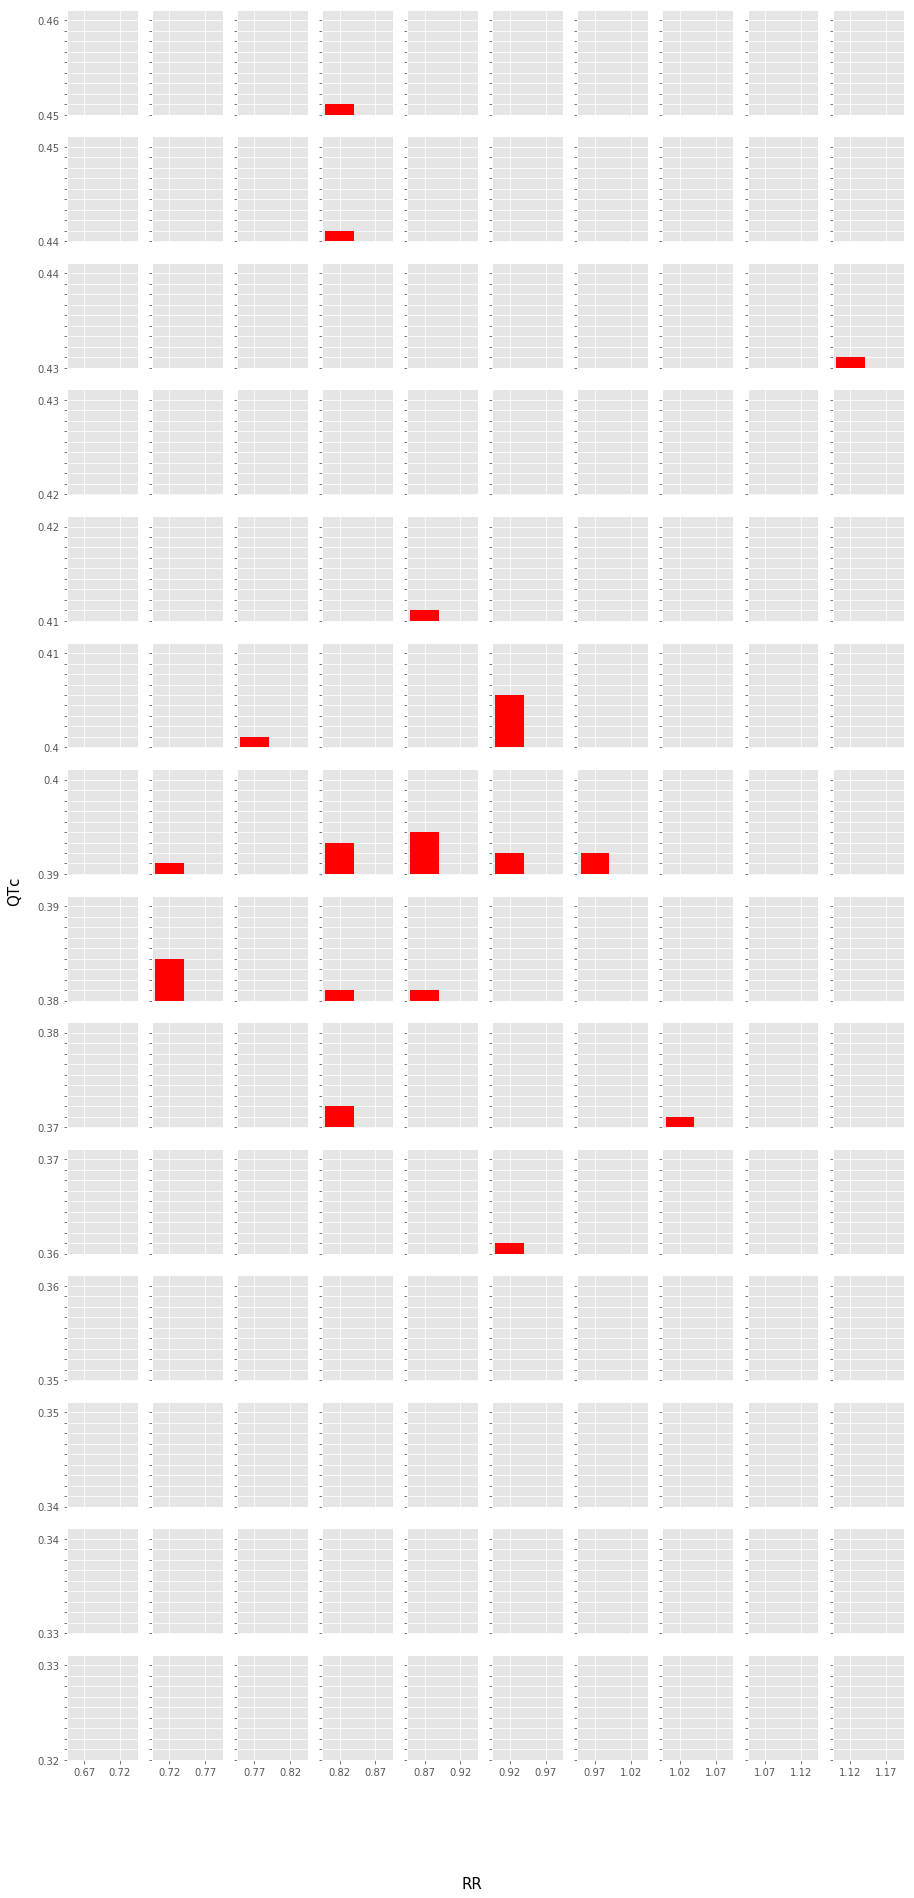

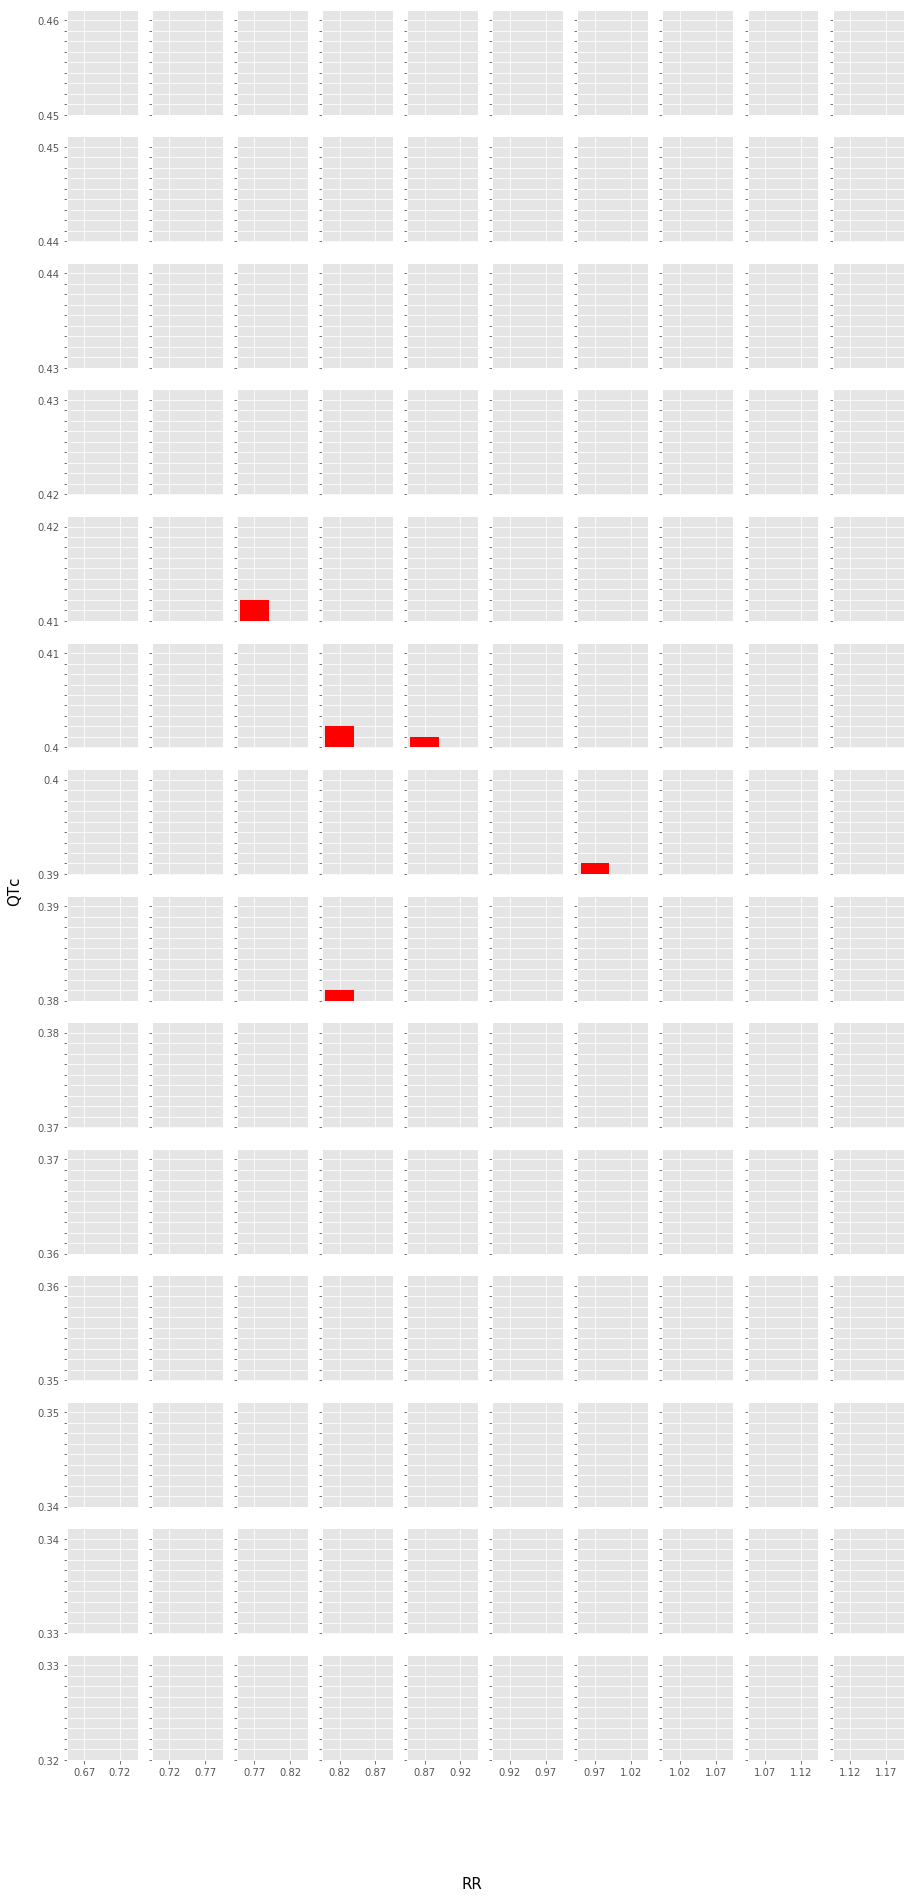

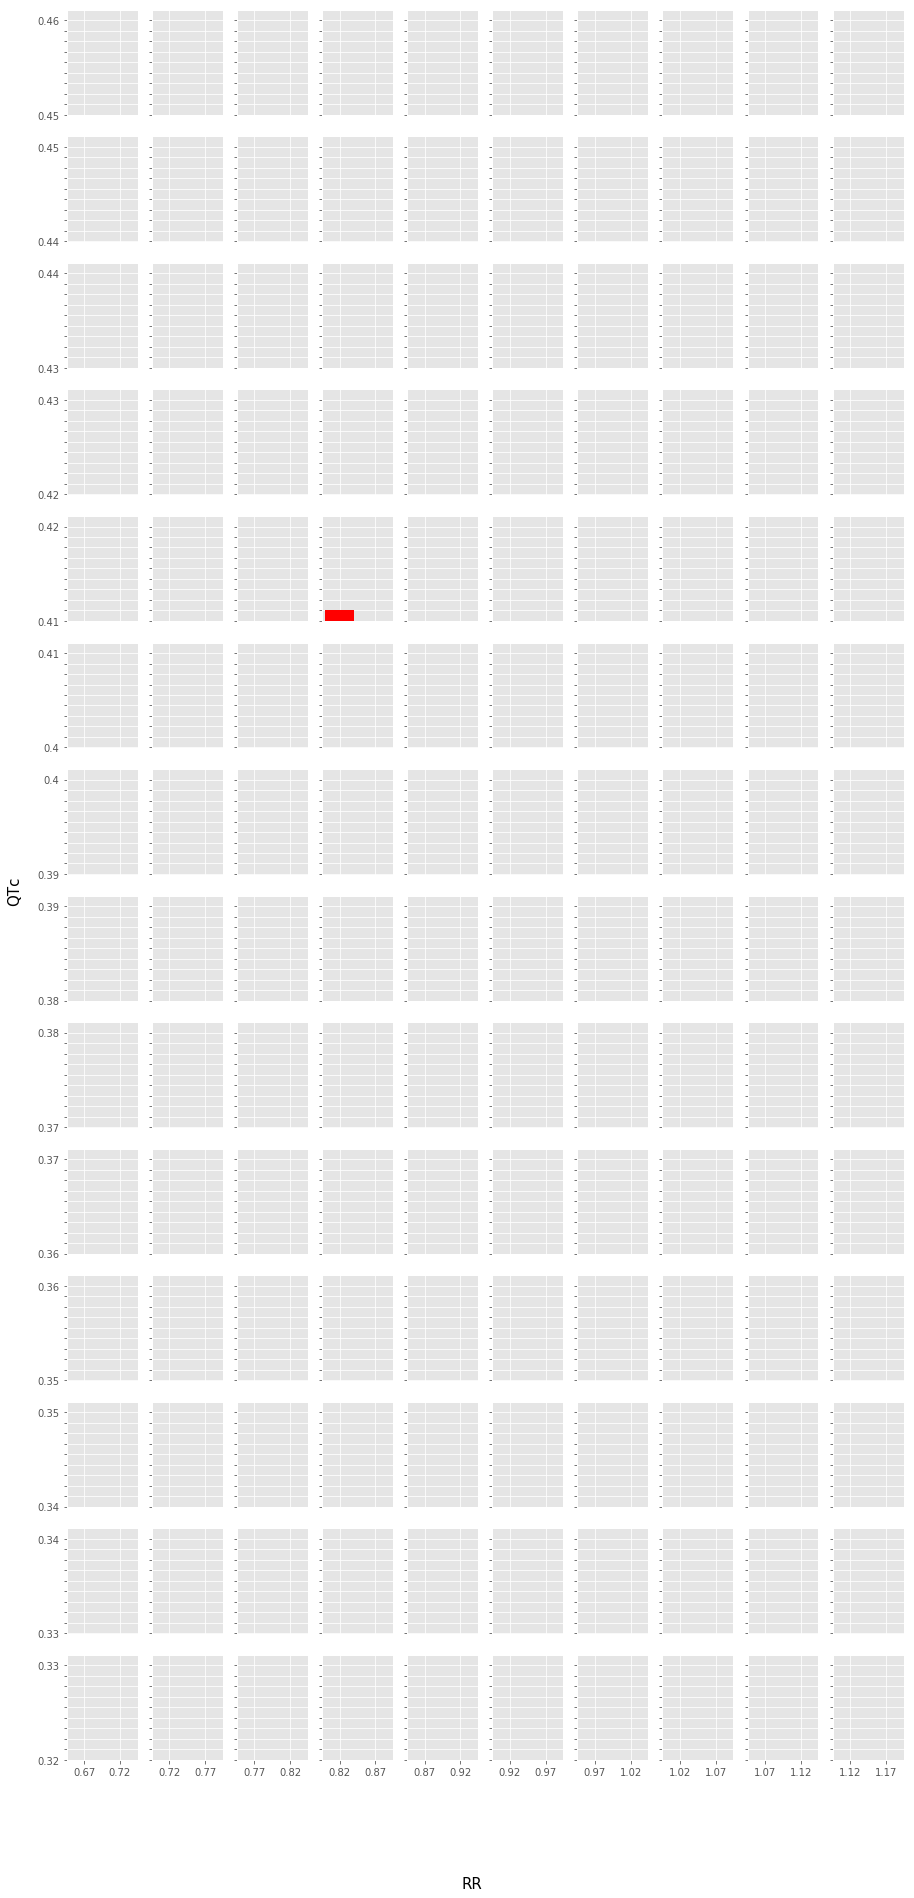

In [94]:
def tostr(val):
    return str(np.round(val, 3))
plt.style.use('ggplot')
def build_plots(tables_heal, tables_sick, plots_thresh_space, threshX, threshY, feat, featX, featY):
    pts=plots_thresh_space; s=plots_thresh_space.size-1; sX=threshX.size-1; sY=threshY.size-1
    plt.rcParams['figure.figsize'] = (1.5*sY, 2.3*sX)
    threshX = threshX[::-1]
    n_yticks = 10;
    for ii in range(s):
        t1 = tables_heal[ii][::-1]
        t2 = tables_sick[ii][::-1]
        fig, ax = plt.subplots(sX, sY, sharex='col', sharey='row')
        fig.text(0.5, 0.07, plot_labels[featY], ha='center', fontsize=15)
        fig.text(0.07, 0.5, plot_labels[featX], va='center', rotation='vertical', fontsize=15)
        for i in range(sX):
            for j in range(sY):
                _ax = ax[i, j]
                plt.sca(_ax)
                l = ["" for _ in range(n_yticks)]; l[0] = tostr(threshX[i+1]); l[-1] = tostr(threshX[i])
                _ax.set_yticklabels(l)

                if i == sX-1:
                    _ax.set_xticklabels([tostr(threshY[j]), tostr(threshY[j+1])])
                    plt.xticks([0, 1])
                else:
                    _ax.tick_params(axis='x', which='both', length=0)
                
                plt.bar([0], t2[i, j], width=0.8, color='red')
                plt.bar([1], t1[i, j], width=0.8, color='green')
                plt.ylim(ymax = n_yticks)
                plt.yticks(range(n_yticks))
        plot_name = plots_dir+"\\"+str(ii)+"_"+plot_labels[feat]+"_"+tostr(pts[ii])+"-"+tostr(pts[ii+1])+".jpg"
        plt.savefig(plot_name, bbox_inches='tight')
        plt.show()
        
build_plots(tables_heal, np.round(tables_sick), plots_thresh_space, threshX, threshY, feat_base, featX, featY)                

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [92]:
def cut_tails(vec, STEP=0.005, n=3, p=0.01):
    n_cut = np.round(p*vec.size)
    start = np.round(vec.min(), n)
    stop = np.round(vec.max(), n)
    thr = np.arange(start, stop+STEP, STEP)
    print(thr.size)
    print(thr)
    e1=0; e2=0;
    for i in range(thr.size):
        if (vec<thr[i]).sum() >= n_cut:
            e1 = i
            break
            
    for i in range(thr.size-1, 0, -1):
        if (vec>thr[i]).sum() >= n_cut:
            e2 = i
            break

    return thr[e1:e2]
f = 2
vec = np.concatenate((data_heal[:, f], data_sick[:, f], data_very_sick[:, f]))
thr = cut_tails(vec, STEP=0.05)
print()
print(thr)
plot_labels[f]

13
[0.024 0.074 0.124 0.174 0.224 0.274 0.324 0.374 0.424 0.474 0.524 0.574
 0.624]

[]


'TpeakTend'

In [78]:
data = data_sick
pts = plots_thresh_space

m1 = get_mask(data[:, 0], 0.41, 0.42)
m2 = get_mask(data[:, 1], 0.29, 0.3)
m3 = get_mask(data[:, 2], 0.06, 0.07)
(m1*m2*m3).sum()

8